# HW 2 Multimodal Machine Learning for Emotion Recognition

- main with sub notebooks
    1. audio (acoustic) 
    2. text (lexical)
    3. visual (this notebook)
    4. early fusion 
    5. late fusion 
    6. results
    
- `%load` and `%run` with [cell magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-load): This allows us to get code from another notebook

In [1]:
main_notebook = 'main.ipynb'

In [2]:
# %load main_notebook

In [3]:
%run 'main.ipynb'

# 1. Load Data + Reduce Temporal Dimension + Split into Sets

In [4]:
specific_feature = 'visual_features'
visual_features_paths, visual_features_with_y = build_paths_to_file(dataset_paths_copy, specific_feature)

In [5]:
visual_ys_series = visual_features_with_y.loc[0:, 'emotion_labels']
visual_reduced_temporal_dimensions, visual_true_labels = reduce_temporal_dimension(visual_features_paths, visual_ys_series)
np.shape(visual_reduced_temporal_dimensions), np.shape(visual_true_labels)

((1336, 2048), (1336,))

In [6]:
test_size = 0.7
X_train_visual, X_test_visual, X_val_visual, y_train_visual, y_test_visual, y_val_visual = split_data(visual_reduced_temporal_dimensions, visual_true_labels, test_size)

[INFO] X, y TRAIN sets
(400, 2048) (400,)

[INFO] X, y TEST sets
(936, 2048) (936,)

[INFO] X, y TRAIN sets
(120, 2048) (120,)

[INFO] X, y VALIDATION sets
(280, 2048) (280,)


## 2. Perform a Unimodal 4-Class Emotion Classification

See my [HW 2 Notes](https://detraviousjbrinkley.notion.site/HW-2-Multimodal-Machine-Learning-for-Emotion-Recognition-4967e03039b04f20907996de25f6068a) for more details on 
1. Support Vector Machine (SVM)
2. Support Vector Classification (SVC)
3. Note that LinearSVC does not accept parameter kernel, as this is assumed to be linear per the [SVM documentation](https://scikit-learn.org/stable/modules/svm.html#multi-class-classification)

### Without Hyper-Parameter Tuning

- `score()` uses coefficient of determination. The coefficient will have a value in the range [0, 1], where 0 implies that we cannot predict the target output correctly, while a value of 1 implies we can perfectly predict the output with no error. Read more: (1) https://pyimagesearch.com/2021/05/17/introduction-to-hyperparameter-tuning-with-scikit-learn-and-python/ or (2) https://stattrek.com/statistics/dictionary?definition=coefficient_of_determination

- Output of `score()` shows that we obtain a coefficient of determination value of ~0.374, meaning that 37% of the variance in Y (our 4 different emotion classes) is predictable based on X (our **visual** feature values)

[INFO] training our linear support vector classification estimator
[INFO] fitting on TRAIN...
[INFO] classification on TEST...
              precision    recall  f1-score   support

           0       0.29      0.34      0.31       227
           1       0.33      0.40      0.36       211
           2       0.25      0.13      0.17       122
           3       0.45      0.42      0.44       376

    accuracy                           0.36       936
   macro avg       0.33      0.32      0.32       936
weighted avg       0.36      0.36      0.36       936



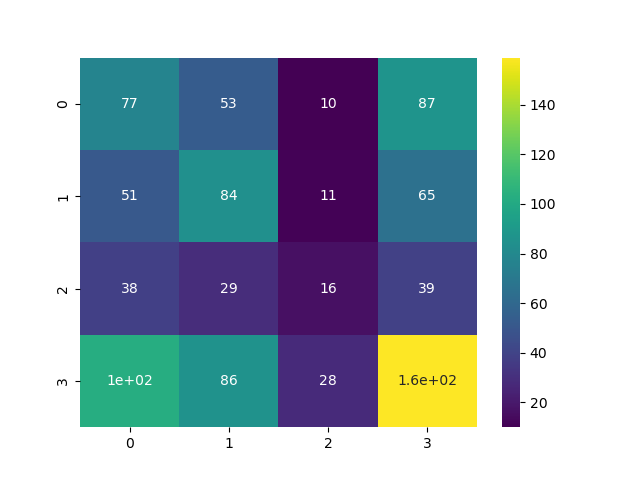

[INFO] evaluating on TEST...
0.358974358974359
0.358974358974359


In [7]:
print("[INFO] training our linear support vector classification estimator")
# initialize the LinearSVC() estimator 
visual_classification_estimator = svm.LinearSVC()

print("[INFO] fitting on TRAIN...")
# train the model without hyperparameter tuning
train_without_hp_visual = visual_classification_estimator.fit(X_train_visual, y_train_visual)
# print(train_without_hp)

print("[INFO] classification on TEST...")
# make a prediction (returns a list of 0 - 4 values)
y_pred_without_hp_visual = train_without_hp_visual.predict(X_test_visual)

visual_classification_report_without_hp = classification_report(y_test_visual, y_pred_without_hp_visual)
print(visual_classification_report_without_hp)

# show true labels and predictions
visual_cm = confusion_matrix(y_test_visual, y_pred_without_hp_visual)
sns.heatmap(visual_cm, annot=True, cmap='viridis')
plt.show()

print("[INFO] evaluating on TEST...")
test_without_hp_visual = train_without_hp_visual.score(X_test_visual, y_test_visual)
print(test_without_hp_visual)

visual_f1_micro_without_hp = f1_score(y_test_visual, y_pred_without_hp_visual, average='micro')
print(visual_f1_micro_without_hp)

### With Hyper-Parameter Tuning

- Search hyper-parameters of the `LinearSVC()` estimator and find the optimal values
- Output of `score()` shows that we obtain a coefficient of determination value of ~0.395, meaning that 40% of the variance in Y (our 4 different emotion classes) is predictable based on X (our **visual** feature values). This is an increase from 37% without hyper-parameter tuning.

In [8]:
# initialize the LinearSVC() estimator 
classification_estimator = svm.LinearSVC()

# define the hyper-parameters to perform the grid search over
param_grid = {
    'C': [0.01, 0.1, 10, 100], 
    # 'class_weight': [1],
    # 'dual':,
    'fit_intercept': [True, False],
    # 'intercept_scaling':,
    'loss': ['hinge', 'squared_hinge'],
    # 'max_iter':,
     # 'multi_class': [1],
    # 'penalty': ['l1', 'l2'],
    'penalty': ['l2'],
    # 'random_state':,
    # 'tol': , 
    # 'verbose':    
}

print("[INFO] grid searching over the hyper-parameters...")
# perform grid search with our estimator, hyper-parameters, cross-validation
linear_classification = GridSearchCV(classification_estimator, param_grid=param_grid, cv=10)
linear_classification

[INFO] grid searching over the hyper-parameters...


GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 10, 100],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l2']})

[INFO] fitting on TRAIN...
[INFO] classification on TEST...
              precision    recall  f1-score   support

           0       0.30      0.34      0.32       227
           1       0.37      0.42      0.39       211
           2       0.17      0.10      0.13       122
           3       0.48      0.47      0.47       376

    accuracy                           0.38       936
   macro avg       0.33      0.33      0.33       936
weighted avg       0.37      0.38      0.37       936



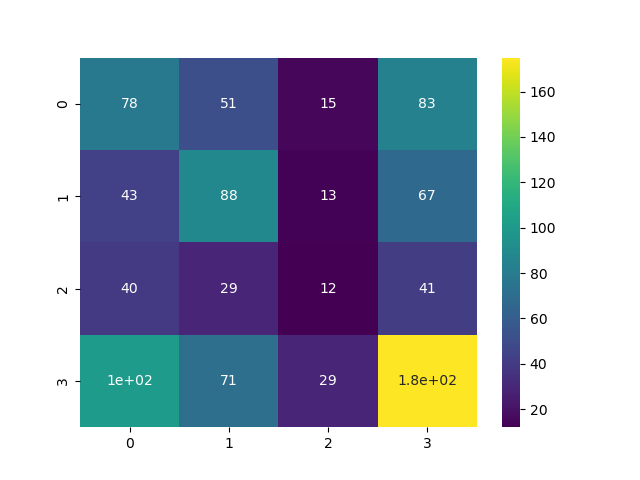


[INFO] evaluating on TEST...
0.37713675213675213
0.3771367521367522


In [9]:
print("[INFO] fitting on TRAIN...")
# train the model with hyperparameter tuning on all permutation parameters
train_with_hp_visual = linear_classification.fit(X_train_visual, y_train_visual)
# train_with_hp

print("[INFO] classification on TEST...")
# make a prediction (returns a list of 0 - 4 values)
y_pred_with_hp_visual = train_with_hp_visual.predict(X_test_visual)

visual_classification_report = classification_report(y_test_visual, y_pred_with_hp_visual)
print(visual_classification_report)

# show true labels and predictions
cm = confusion_matrix(y_test_visual, y_pred_with_hp_visual)
sns.heatmap(cm, annot=True, cmap='viridis')
plt.show()

print("\n[INFO] evaluating on TEST...")
# evaluate on the best model with hyperparameter tuning model
validation_with_hp_visual = train_with_hp_visual.score(X_test_visual, y_test_visual)
print(validation_with_hp_visual)

visual_f1_micro_with_hp = f1_score(y_test_visual, y_pred_with_hp_visual, average='micro')
print(visual_f1_micro_with_hp)